In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root='./datasets', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./datasets', train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\MNIST\raw

Processing...


C:\Users\dell\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
print("Number of training examples:{}".format(len(mnist_train)))
print('Number of test examples:{}'.format(len(mnist_test)))

Number of training examples:60000
Number of test examples:10000


Default image shape:torch.Size([1, 28, 28])
Reshaped image shape:torch.Size([28, 28])
The label for this image is:1


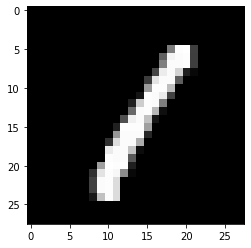

In [29]:
image, label = mnist_train[3]

print('Default image shape:{}'.format(image.shape))
#change three dimensional value to two.
image = image.reshape([28, 28])
print("Reshaped image shape:{}".format(image.shape))
plt.imshow(image, cmap='gray')

print("The label for this image is:{}".format(label))

In [5]:
#take small batch size to train and test
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [9]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of minibatch images:{}".format(images.shape))
print("Shape of minibatch labels:{}".format(labels.shape))

Shape of minibatch images:torch.Size([100, 1, 28, 28])
Shape of minibatch labels:torch.Size([100])


# Logistic Regression Model

In [10]:
#change the image to single dimension.
x = images.view(-1, 28*28)
print("Shape of input x: {}".format(x.shape))

Shape of input x: torch.Size([100, 784])


In [11]:
#randomly initialize the weights 
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

#initialize bias b as 0
b = torch.zeros(10, requires_grad=True)

In [13]:
y = torch.matmul(x, W) + b

In [14]:
print(y[0,:])

tensor([-0.0897,  0.5140, -0.3944, -0.2081, -0.0492, -0.7428, -0.1496,  0.0681,
        -0.0738,  0.4876], grad_fn=<SliceBackward>)


In [15]:
#find softmax from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

#Alternate way: with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print('py[0] with torch.nn.functional.softmax: {}'.format(py[0]))

py[0] from equation: tensor([0.0915, 0.1674, 0.0675, 0.0813, 0.0953, 0.0476, 0.0862, 0.1072, 0.0930,
        0.1630], grad_fn=<SelectBackward>)
py[0] with torch.nn.functional.softmax: tensor([0.0915, 0.1674, 0.0675, 0.0813, 0.0953, 0.0476, 0.0862, 0.1072, 0.0930,
        0.1630], grad_fn=<SelectBackward>)


In [16]:
print(labels.shape)

torch.Size([100])


In [18]:
#cross-entropy loss
#From equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]), labels])
print('Cross entropy from equation:{}'.format(cross_entropy_eq))

#cross entropy with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("Cross entropy with torch.nn.functional:{}".format(cross_entropy))

Cross entropy from equation:2.3038084506988525
Cross entropy with torch.nn.functional:2.3038082122802734


# Backward Pass

In [19]:
#optimizer
optimizer = torch.optim.SGD([W, b], lr=0.1)

In [20]:
cross_entropy.backward()

In [22]:
b.grad

tensor([-0.0013, -0.0121, -0.0430, -0.0247, -0.0016, -0.0171,  0.0223,  0.0013,
         0.0269,  0.0492])

In [23]:
optimizer.step()

In [24]:
b

tensor([ 0.0001,  0.0012,  0.0043,  0.0025,  0.0002,  0.0017, -0.0022, -0.0001,
        -0.0027, -0.0049], requires_grad=True)

In [27]:
print("b.grad before zero_grad():{}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad():tensor([-0.0013, -0.0121, -0.0430, -0.0247, -0.0016, -0.0171,  0.0223,  0.0013,
         0.0269,  0.0492])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# Model Training

In [28]:
#iterate through train set minibatch
for images, labels in tqdm(train_loader):
    optimizer.zero_grad()
    
    #forward
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    
    #Backward
    cross_entropy.backward()
    optimizer.step()
    

# Testing

In [32]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print("Test accuracy: {}".format(correct/total))


Test accuracy: 0.9017000198364258


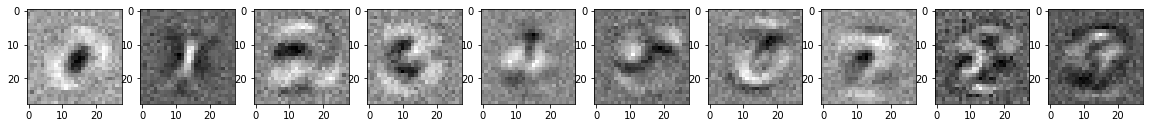

In [33]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28, 28), cmap='gray')

# Higher level API

In [34]:
class xW_plus_b:
    def __init__(self, dim_in, dim_out):
        self.W = torch.randn(dim_in, dim_out) / np.sqrt(dim_in)
        self.W.requires_grad_()
        self.b = torch.zeros(dim_out, requires_grad=True)
    
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

In [38]:
lin_custom = xW_plus_b(784, 10)
print("W: {}".format(lin_custom.W.shape))
print("b:{}".format(lin_custom.b.shape))

W: torch.Size([784, 10])
b:torch.Size([10])


In [36]:
x_rand = torch.randn(1, 784)
y = lin_custom.forward(x_rand)
print(y.shape)

torch.Size([1, 10])


# using torch.nn

In [39]:
import torch.nn as nn

In [40]:
lin = nn.Linear(784, 10)
print("Linear parameters: {}".format([p.shape for p in lin.parameters()]))

y = lin(x_rand)
print(y.shape)

Linear parameters: [torch.Size([10, 784]), torch.Size([10])]
torch.Size([1, 10])


In [42]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, x):
        return self.lin(x)

In [44]:
model = MNIST_Logistic_Regression()
y = model(x_rand)
print('Model:{}'.format(model))
print('\n Parameters:{}'.format(list(model.parameters())))
print("\n Output shape:{}".format(y.shape))

Model:MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

 Parameters:[Parameter containing:
tensor([[ 0.0221, -0.0089, -0.0188,  ...,  0.0267, -0.0214, -0.0283],
        [ 0.0272,  0.0012,  0.0136,  ...,  0.0308,  0.0346,  0.0249],
        [ 0.0154, -0.0047, -0.0167,  ..., -0.0188,  0.0318, -0.0228],
        ...,
        [-0.0029,  0.0235, -0.0172,  ...,  0.0356,  0.0239,  0.0281],
        [ 0.0235,  0.0327,  0.0004,  ..., -0.0024, -0.0303, -0.0227],
        [ 0.0315, -0.0220,  0.0110,  ..., -0.0128,  0.0099,  0.0107]],
       requires_grad=True), Parameter containing:
tensor([-0.0077, -0.0102, -0.0052, -0.0167, -0.0251, -0.0321,  0.0237,  0.0246,
         0.0262,  0.0315], requires_grad=True)]

 Output shape:torch.Size([1, 10])


# Full implementation

In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, x):
        return self.lin(x)
    
#load data
mnist_train = datasets.MNIST(root='./datasets', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./datasets', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

#instantiate model
model = MNIST_Logistic_Regression()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for images, labels in tqdm(train_loader):
    optimizer.zero_grad()
    
    #forward
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    
    #Backward
    loss.backward()
    optimizer.step()
    
correct = 0
total = len(mnist_test)

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print("Test accuracy: {:2f}".format(correct/total))
    
    



Test accuracy: 0.903300
